<div style="padding:0px 40px 30px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;"> 


<h1 style = "text-align:center;
             font-size:40px;"> Ведение </h1>
    
<h2 style = "text-align:center;
             font-size:30px;"> Описание задачи </h2>
    
Перед нами стоит задача предсказать стоимость б/у автомобиля и проверить нашу модель на тестовой выборке. Мы будем использовать метрику MAPE (Mean Absolute Percentage Error) и стремиться достичь минимального значения.

    
    
    
![MAPE](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F452676%2F99bf86af22241438a654f7e8eecf294e%2F2023-03-20%20%2017.16.01.png?generation=1679314590278751&alt=media)

Работа выполнена в рамках конкурса Kaggle: https://www.kaggle.com/competitions/used-cars-price-prediction/leaderboard

<h2 style = "text-align:center;
             font-size:30px;"> Описание данных </h2>

Датасет содержит следующие признаки:

- 'year' - год производства автомобиля;
- 'make' - производитель автомобиля;
- 'model' - модель автомобиля;
- 'trim' - модификация автомобиля;
- 'body' - тип кузова автомобиля;
- 'transmission' - тип КПП;
- 'vin' - идентификатор (вин) автомобиля;
- 'state' - штат регистрации автомобиля;
- 'condition' - состояние автомобиля по шкале от 1 до 5;
- 'odometer' - пробег автомобиля в милях;
- 'color' - цвет кузова автомобиля;
- 'interior' - цвет интерьера автомобиля;
- 'seller' - продавец автомобиля;
- 'saledate' - дата продажи автомобиля.

Целевым признаком является 'sellingprice' - стоимость продажи автомобиля.
<h2 style = "text-align:center;
             font-size:30px;"> План работы </h2>
    
1. Загрузка и предобработка данных.
2. Обучение различных моделей:
- CatBoost;
- LightGBM;
- Random Forest;
- Линейные модели;
- KNeighbors;
- Голосование (Voting).
3. Выбор наилучшей модели.
4. Анализ влияния различных параметров на результат.
5. Выполнение прогноза для тестовой выборки.


<div style="padding:0px 20px 20px; 
            color:#004346;
            margin:0px;
            font-size:20px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">
    
# Импортируем библиотеки

In [1]:
import warnings

import matplotlib.pyplot as plt
import category_encoders as ce
import lightgbm as lg
import seaborn as sns
import pandas as pd
import numpy as np
import optuna

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin
from dython.nominal import associations # Библиотека для вывода кореляций.
from sklearn.base import BaseEstimator
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from catboost import Pool

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge


warnings.filterwarnings('ignore')

<div style="padding:0px 20px 20px; 
            color:#004346;
            margin:0px;
            font-size:20px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">
    
# Загрузка данных и знакомство

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(f"Размер тренеровочных данных: {train.shape}\nРазмер тестовых данных: {test.shape}\n")

Размер тренеровочных данных: (440236, 15)
Размер тестовых данных: (110060, 14)



In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


<div style="padding:20px 40px 10px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;"> 

Можно заметить ошибки, а именно:
- **saledate - дата продажи, следовательно этот столбец следует преобразовать в тип datetime.**
- **vin - идентификатор (вин), это поле не пригодиться при пронозе цены, но будет нужна для составления финальной таблицы. Выводим столбец в качестве index.**

In [4]:
def simple_preproc(df):
    df = df.set_index('vin', drop = True)
    df['saledate'] = pd.to_datetime(df['saledate'], utc = True)
    return df

simple = FunctionTransformer(simple_preproc)
simple_preproc = Pipeline(steps = [('Simple_Editing', simple)])
train = simple_preproc.fit_transform(train)

<div style="padding:0px 20px 20px; 
            color:#004346;
            margin:0px;
            font-size:20px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">
    
# Изучение данных

<div style="padding:0px 40px 20px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
<h2 style = "text-align:center;
             font-size:30px;"> Изучение пропусков

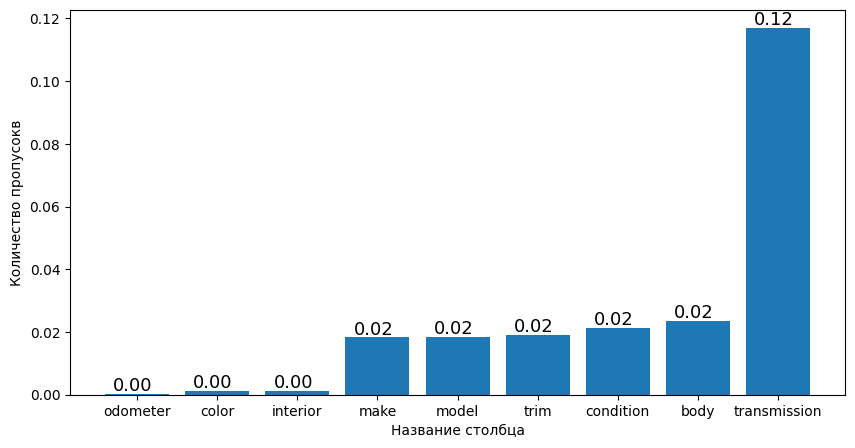

In [5]:
x = (train.isna().sum()[train.isna().sum() > 0] / len(train)).sort_values()
plt.figure(figsize = (10, 5))
plt.bar(x.index, x)
plt.xlabel('Название столбца')
plt.ylabel('Количество пропусокв')
for index,data in enumerate(x):
    plt.text(x=index - 0.3, y =data + 0.001, s=f"{data:.{2}f}" , fontdict=dict(fontsize=13))
plt.show();

<div style="padding:20px 40px 20px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;">  
Большое количество пропусков в transmission - тип КПП, очень схожая доля пропусков в make - производитель, model - модель, trim - модификация, следует расмотреть совпадение пропусков в трех этих столбцах.

In [6]:
mask = train['make'].isna() & train['model'].isna() & train['trim'].isna() & train['body'].isna()
print(f'Количество пропусков: {len(train[mask])}\nДоля пропусков: {len(train[mask]) / len(mask)}')

Количество пропусков: 8043
Доля пропусков: 0.018269746227023688


<div style="padding:10px 40px 10px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;">

Большая часть пропусков совпадают, предположительно это ошибка заполнения.

In [7]:
train[train['condition'].isna()]['odometer'].describe()

count      9356.000000
mean     117829.321077
std       57801.225857
min           1.000000
25%       81701.000000
50%      116012.000000
75%      152712.750000
max      999999.000000
Name: odometer, dtype: float64

<div style="padding:10px 40px 10px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;">
Обычно состояние не указывают машины с большим пробегом. 

<div style="padding:20px 40px 10px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;">
    
Итого:
- **Color и interior заполним '-';**
- **Пропуски в численных переменных заполнем методом KNNImputer;**
- **Пропуски в оставшихся категориальных переменных заполним значением: 'NotState';**

In [8]:
def custom_imputer(X):
    categ_column = X.select_dtypes(include=['object']).columns
    X[['color', 'interior']] = X[['color', 'interior']].fillna('-')
    X[categ_column] = X[categ_column].fillna('Not_State')
    return X


class NumericImputer(BaseEstimator, TransformerMixin):

    def __init__(self, imputer = KNNImputer()): 
        self.imputer = imputer

    def fit(self, X, y=None):
        self.numeric = X.select_dtypes(include=['int', 'float']).drop('sellingprice', axis = 1).columns
        self.imputer.fit(X[self.numeric])
        return self

    def transform(self, X):
        X[self.numeric] = self.imputer.transform(X[self.numeric])
        return X


custom_imputer = FunctionTransformer(custom_imputer)
Imputing = Pipeline(
    steps=[('Categ_Imputing',custom_imputer),
           ('Numeric_Transform', NumericImputer())])
train = Imputing.fit_transform(train)

In [9]:
print('Количество пропусков на тренеровачных данных', train.isna().sum().sum())

Количество пропусков на тренеровачных данных 0


<div style="padding:0px 40px 20px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
<h2 style = "text-align:center;
             font-size:30px;"> Изучение количественных столбцов

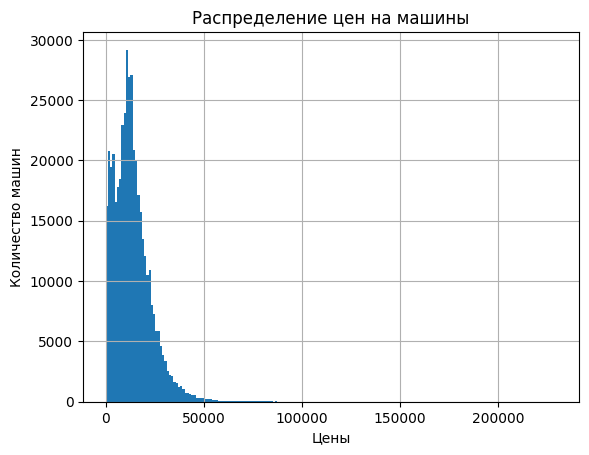

In [10]:
train['sellingprice'].hist(bins = 200)
plt.title('Распределение цен на машины')
plt.xlabel('Цены')
plt.ylabel('Количество машин')
plt.show();

<div style="padding:10px 40px 10px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;"> 

Имеются выбросы сврху и снизу, выбросы сверху оставим, потому что дорогие машины, это не что-то особенное.

Выброс снизу так-же будем считать особенностями, возможно это сломанные машины после аварий.

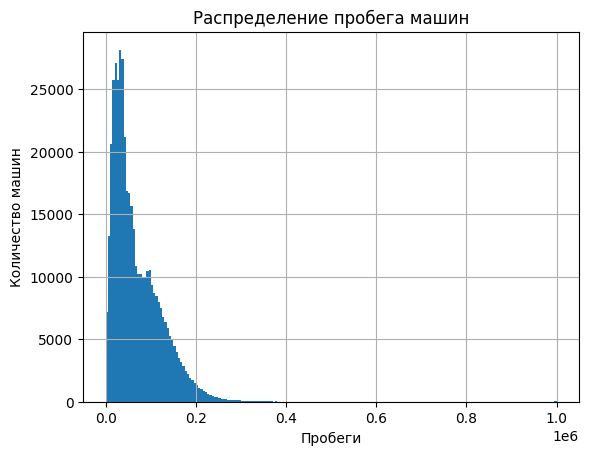

In [11]:
train['odometer'].hist(bins = 200)
plt.title('Распределение пробега машин')
plt.xlabel('Пробеги')
plt.ylabel('Количество машин')
plt.show();

<div style="padding:10px 40px 10px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
odometer также имеет значительные выбросы, будет это считать особенностью.
<br><br>
Также odometer и sellingprice не сметричны, поэтому прологарифмируем эти стобцы чтобы сделать данные более симетричнымы.

In [12]:
def numeric_transform(X):
    if 'sellingprice' in X.columns:
        X['sellingprice'] = np.log(X.sellingprice + 1)
    X['odometer'] = np.log(X.odometer + 1)
    return X

numeric_transform = FunctionTransformer(numeric_transform)
numeric_piepline = Pipeline(steps = [('Logarifming_Numeric', numeric_transform)])
train = numeric_piepline.fit_transform(train)

<div style="padding:0px 40px 20px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
<h2 style = "text-align:center;
             font-size:30px;"> Изучение количественных столбцов после логарифмирования.

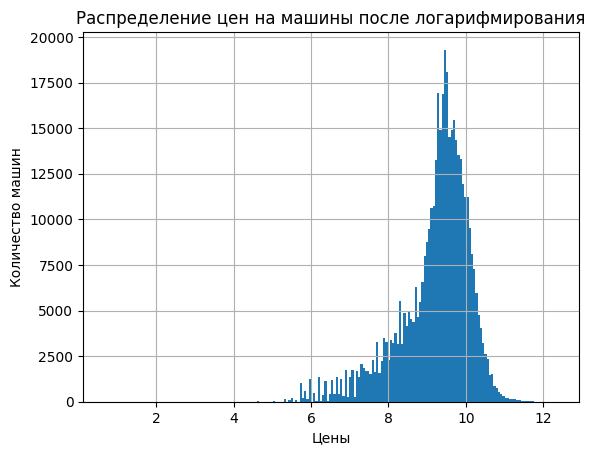

In [13]:
train['sellingprice'].hist(bins = 200)
plt.title('Распределение цен на машины после логарифмирования')
plt.xlabel('Цены')
plt.ylabel('Количество машин')
plt.show();

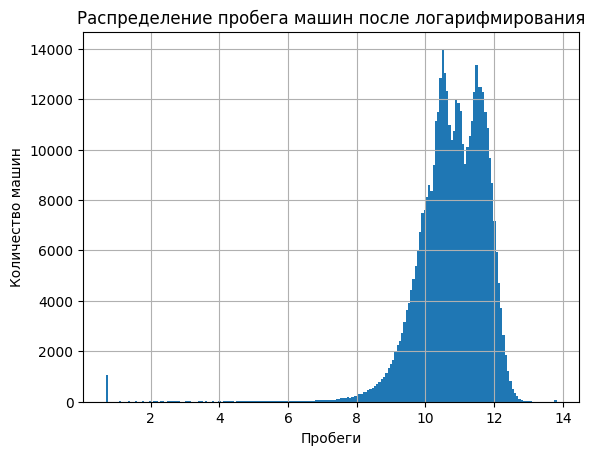

In [14]:
train['odometer'].hist(bins = 200)
plt.title('Распределение пробега машин после логарифмирования')
plt.xlabel('Пробеги')
plt.ylabel('Количество машин')
plt.show();

<div style="padding:0px 40px 20px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
<h2 style = "text-align:center;
             font-size:30px;"> Изучение явных дубликатов 

In [15]:
train.duplicated().sum()

0

<div style="padding:10px 40px 10px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;"> 

Явных дубликатов не найдено, возможно они проявят себя после обработки категормальных данных.

<div style="padding:0px 40px 20px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
<h2 style = "text-align:center;
             font-size:30px;"> Изучение категориальных столбцов

In [16]:
categ_column = [column for column in train.columns if train[column].dtype == 'O']

In [17]:
categ_uniq = [len(train[column].unique()) for column in categ_column]
pd.Series(data = categ_uniq, index = categ_column)

make               93
model             960
trim             1923
body               86
transmission        3
state              38
color              21
interior           18
seller          13025
dtype: int64

<div style="padding:20px 40px 10px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
    
- **Переведем категориальные перемнные в нижний регистр**

In [18]:
print(sorted(train['make'].unique()))

['Acura', 'Aston Martin', 'Audi', 'BMW', 'Bentley', 'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Daewoo', 'Dodge', 'FIAT', 'Ferrari', 'Fisker', 'Ford', 'GMC', 'Geo', 'HUMMER', 'Honda', 'Hyundai', 'Infiniti', 'Isuzu', 'Jaguar', 'Jeep', 'Kia', 'Lamborghini', 'Land Rover', 'Lexus', 'Lincoln', 'MINI', 'Maserati', 'Mazda', 'Mercedes-Benz', 'Mercury', 'Mitsubishi', 'Nissan', 'Not_State', 'Oldsmobile', 'Plymouth', 'Pontiac', 'Porsche', 'Ram', 'Rolls-Royce', 'Saab', 'Saturn', 'Scion', 'Subaru', 'Suzuki', 'Tesla', 'Toyota', 'Volkswagen', 'Volvo', 'acura', 'airstream', 'audi', 'bmw', 'buick', 'cadillac', 'chevrolet', 'chrysler', 'dodge', 'dodge tk', 'dot', 'ford', 'ford truck', 'gmc', 'gmc truck', 'honda', 'hyundai', 'jeep', 'kia', 'land rover', 'landrover', 'lexus', 'lincoln', 'maserati', 'mazda', 'mazda tk', 'mercedes', 'mercedes-b', 'mercury', 'mitsubishi', 'nissan', 'oldsmobile', 'plymouth', 'pontiac', 'porsche', 'smart', 'subaru', 'suzuki', 'toyota', 'volkswagen', 'vw']


<div style="padding:20px 40px 10px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;"> 

Наблюдаются ошибки в заполнении данных, например:
- **vw = volkswagen**
- **mercedes = mercedes-b = mercedes-benz**
- **и так далее.**

In [19]:
print(sorted(train['color'].unique()))

['-', 'beige', 'black', 'blue', 'brown', 'burgundy', 'charcoal', 'gold', 'gray', 'green', 'lime', 'off-white', 'orange', 'pink', 'purple', 'red', 'silver', 'turquoise', 'white', 'yellow', '—']


In [20]:
print(sorted(train['interior'].unique()))

['-', 'beige', 'black', 'blue', 'brown', 'burgundy', 'gold', 'gray', 'green', 'off-white', 'orange', 'purple', 'red', 'silver', 'tan', 'white', 'yellow', '—']


<div style="padding:10px 40px 10px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
Неявных ошибок в стобцах interior и color не наблюдается.

In [21]:
print(sorted(train['body'].unique()))

['Access Cab', 'Beetle Convertible', 'CTS Coupe', 'CTS Wagon', 'CTS-V Coupe', 'CTS-V Wagon', 'Cab Plus', 'Cab Plus 4', 'Club Cab', 'Convertible', 'Coupe', 'Crew Cab', 'CrewMax Cab', 'Double Cab', 'E-Series Van', 'Elantra Coupe', 'Extended Cab', 'G Convertible', 'G Coupe', 'G Sedan', 'G37 Convertible', 'G37 Coupe', 'Genesis Coupe', 'GranTurismo Convertible', 'Hatchback', 'King Cab', 'Koup', 'Mega Cab', 'Minivan', 'Not_State', 'Promaster Cargo Van', 'Q60 Convertible', 'Q60 Coupe', 'Quad Cab', 'Ram Van', 'Regular Cab', 'SUV', 'Sedan', 'SuperCab', 'SuperCrew', 'TSX Sport Wagon', 'Transit Van', 'Van', 'Wagon', 'Xtracab', 'access cab', 'beetle convertible', 'cab plus 4', 'club cab', 'convertible', 'coupe', 'crew cab', 'crewmax cab', 'cts coupe', 'cts-v coupe', 'double cab', 'e-series van', 'elantra coupe', 'extended cab', 'g convertible', 'g coupe', 'g sedan', 'g37 convertible', 'g37 coupe', 'genesis coupe', 'granturismo convertible', 'hatchback', 'king cab', 'koup', 'mega cab', 'minivan', '

<div style="padding:20px 40px 10px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;"> 

Наблюдаются ошибки в заполнении данных, например:
- **access cab = cab**
- **beetle convertible = convertible**
- **и так далее.**

In [22]:
def categ_transorm(X):
    dictionary = {
        'make': {
            'vw': 'volkswagen',
            'mercedes-b': 'mercedes',
            'mercedes-benz': 'mercedes',
            'mazda tk': 'mazda',
            'land rover': 'landrover',
            'ford truck': 'ford',
            'dodge tk': 'dodge',
            'gmc truck': 'gmc',
            "chev truck": 'chevrolet'
        },
        'body': {
            'cts coupe': 'coupe',
            'cts wagon': 'wagon',
            'cts-v coupe': 'coupe',
            'cts-v wagon': 'wagon',
            'e-series van': 'van',
            'g convertible': 'convertible',
            'g coupe': 'coupe',
            'g sedan': 'sedan',
            'g37 convertible': 'convertible',
            'g37 coupe': 'coupe',
            'genesis coupe': 'coupe',
            'granturismo convertible': 'convertible',
            'koup': 'coupe',
            'promaster cargo van': 'van',
            'q60 convertible': 'convertible',
            'q60 coupe': 'coupe',
            'regular-cab': 'regular cab',
            'transit van': 'van',
            'tsx sport wagon': 'wagon',
            'ram van': 'van',
            'beetle convertible': 'convertible'
        }
    }
    X = X.drop(['seller'], axis=1)
    categ_column = [column for column in X.columns if X[column].dtype == 'O']
    for column in categ_column:
        X[column] = X[column].str.lower().str.strip()
    X = X.replace(dictionary)
    return X


categ_transorm = FunctionTransformer(categ_transorm)
categ_piepline = Pipeline(steps=[('Logarifming_Numeric', categ_transorm)])
train = categ_piepline.fit_transform(train)

In [23]:
categ_column = [column for column in train.columns if train[column].dtype == 'O']
categ_uniq = [len(train[column].unique()) for column in categ_column]
pd.Series(data = categ_uniq, index = categ_column)

make              55
model            840
trim            1841
body              25
transmission       3
state             38
color             21
interior          18
dtype: int64

<div style="padding:10px 40px 10px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;">
Количество производителей значительно снизилось, остальные столбцы также притерпели маленькие изменения.

<div style="padding:0px 40px 20px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
<h2 style = "text-align:center;
             font-size:30px;"> Изучение кореляций целевого признака.

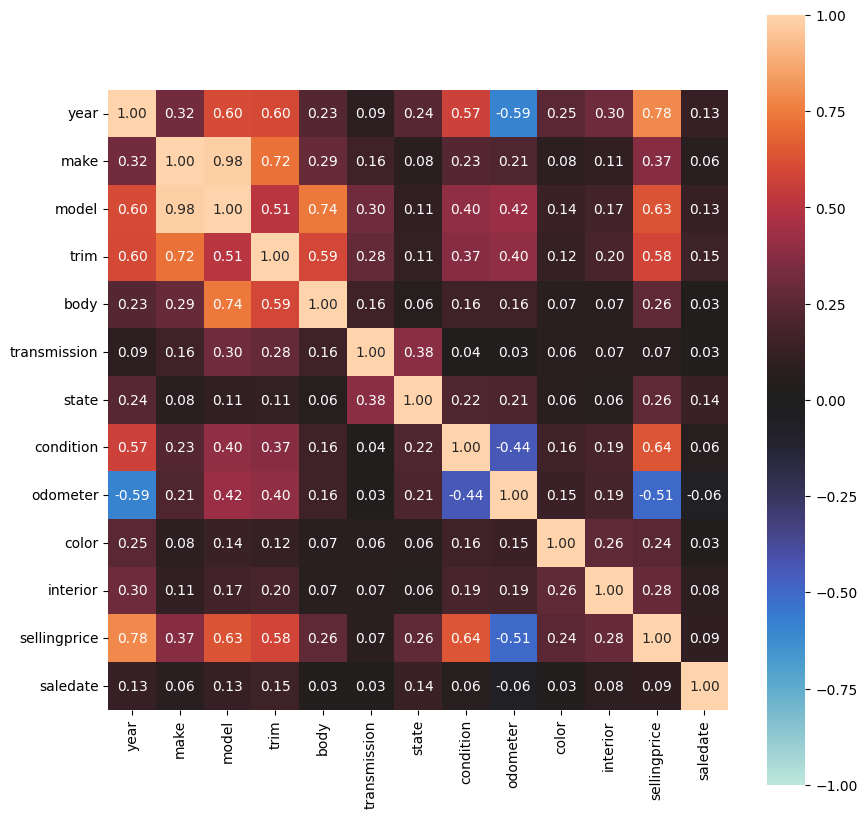

In [24]:
cor = associations(train, nominal_columns='auto', numerical_columns=None, 
             mark_columns=False, nom_nom_assoc='cramer', num_num_assoc='pearson',
             ax=None, figsize=(10,10), annot=True, fmt='.2f',
             cmap=None, sv_color='silver', cbar=True, vmax=1.0, vmin=None, plot=True,
             compute_only=False, clustering=False, title=None, filename=None)

In [25]:
cor['corr']['sellingprice'].drop('sellingprice')

year            0.784709
make            0.370621
model           0.627568
trim            0.578352
body            0.260010
transmission    0.072115
state           0.258432
condition       0.635289
odometer       -0.506310
color           0.244447
interior        0.281275
saledate        0.094483
Name: sellingprice, dtype: float64

<div style="padding:20px 40px 10px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;">
    
- **Целевой признак корелирует достаточно хорошо со всем кроме трансмисии и даты продажи.**
- **Мультикорелиарность не наблюдается.**

<div style="padding:0px 20px 20px; 
            color:#004346;
            margin:0px;
            font-size:20px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

# Обработка перед машинным обучением

<div style="padding:20px 40px 10px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;">

- **Выведем производные даты в отдельные столбцы;**
- **Создадим другие столбцы**

In [26]:
def feature_engineering(X):
    X['sale_year'] = X['saledate'].dt.year
    X['sale_month'] = X['saledate'].dt.month
    X['sale_day'] = X['saledate'].dt.day
    X['sale_hour'] = X['saledate'].dt.hour
    X['sale_minute'] = X['saledate'].dt.minute
    X['sale_dayofweek'] = X['saledate'].dt.dayofweek
    X['year_difference'] = X['sale_year'] - X['year']
    X = X.drop('saledate', axis = 1)
    X['condition_div_by_odometer'] = X['condition'].where(X['year_difference'] != 0, 1) / X['odometer'].replace(0, 1)
    X['make_model'] = X['make'] + X['model']
    X['odometer_div_by_age'] = X['odometer'].where(X['year_difference'] != 0, 1) / X['year_difference'].replace(0, 1)

    return X

feature_engineering = FunctionTransformer(feature_engineering)
feature_engineering_piepline = Pipeline(steps=[('Logarifming_Numeric', feature_engineering)])
train = feature_engineering_piepline.fit_transform(train)

<div style="padding:10px 40px 10px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;">  
Отделим признаки от целевого признака.

In [27]:
target = train['sellingprice']
features = train.drop('sellingprice', axis = 1)

<div style="padding:10px 40px 10px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
Закодируем категориальные переменные. И отделим таргет от признаков.

In [28]:
encoding = Pipeline(steps=[('Logarifming_Numeric', ce.cat_boost.CatBoostEncoder())])
features = encoding.fit_transform(y = target, X = features)

In [29]:
train_features, valid_features, train_target, valid_target = train_test_split(features, target, 
                                                                              test_size=0.20, random_state=42)

<div style="padding:0px 20px 20px; 
            color:#004346;
            margin:0px;
            font-size:20px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

# Подбор модели машинного обучения

<div style="padding:10px 40px 10px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
Для всех моделей проведен подбор гиперпараметров с помощью оптуны.

In [30]:
metrics_model = {}

<div style="padding:0px 40px 20px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
<h2 style = "text-align:center;
             font-size:30px;"> Cat boost

In [31]:
catboost = CatBoostRegressor()
catboost.load_model('best_catboost_regressor')
catboost_res = catboost.predict(valid_features)
metrics_model['cat_boost'] = mean_absolute_percentage_error(valid_target, catboost_res)

<div style="padding:0px 40px 20px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
<h2 style = "text-align:center;
             font-size:30px;"> LightGBM

In [32]:
lgbm_params = {'reg_alpha': 0.03154581496291179, 
               'reg_lambda': 0.07441910099939944, 
               'colsample_bytree': 0.8, 
               'subsample': 0.6, 
               'learning_rate': 0.03, 
               'max_depth': 100, 
               'num_leaves': 179, 
               'min_child_samples': 6}

lgbm = lg.LGBMRegressor(objective="regression", **lgbm_params)
lgbm.fit(train_features, train_target,
         eval_set= [(valid_features, valid_target)],
         eval_metric="mape", early_stopping_rounds=100, verbose=-1)
lgbm_res = lgbm.predict(valid_features)
metrics_model['lgbm'] = mean_absolute_percentage_error(valid_target, lgbm_res)

<div style="padding:0px 40px 20px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
<h2 style = "text-align:center;
             font-size:30px;"> Random Forest

In [33]:
rfr_params = {'n_estimators': 142, 
              'max_depth': 36, 
              'min_samples_split': 3,
              'min_samples_leaf': 1,
              'random_state': 1234}

rfr = RandomForestRegressor(**rfr_params)
rfr.fit(train_features, train_target)
rfr_res = rfr.predict(valid_features)
metrics_model['random_forest'] = mean_absolute_percentage_error(valid_target, rfr_res)

<div style="padding:0px 40px 20px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
<h2 style = "text-align:center;
             font-size:30px;"> Ridge

In [34]:
ridge = Ridge(random_state=1234, alpha = 100)
ridge.fit(train_features, train_target)
ridge_res = ridge.predict(valid_features)
metrics_model['ridge'] = mean_absolute_percentage_error(valid_target, ridge_res)

<div style="padding:0px 40px 20px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
<h2 style = "text-align:center;
             font-size:30px;"> Lasso

In [35]:
lasso = Lasso(random_state=1234, alpha = 0.024798766043596203)
lasso.fit(train_features, train_target)
lasso_res = lasso.predict(valid_features)
metrics_model['lasso'] = mean_absolute_percentage_error(valid_target, lasso_res)

<div style="padding:0px 40px 20px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
<h2 style = "text-align:center;
             font-size:30px;"> KNeighbors

In [36]:
knn_params = {'algorithm': 'auto', 'n_neighbors': 10}
knn = KNeighborsRegressor(**knn_params)
knn.fit(train_features, train_target)
knn_res = knn.predict(valid_features)
metrics_model['knn'] = mean_absolute_percentage_error(valid_target, knn_res)

<div style="padding:0px 40px 20px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
<h2 style = "text-align:center;
             font-size:30px;">Linear Regression

In [37]:
lr = LinearRegression()
lr.fit(train_features, train_target)
lr_res = lr.predict(valid_features)
metrics_model['lr'] = mean_absolute_percentage_error(valid_target, lr_res)

<div style="padding:0px 20px 20px; 
            color:#004346;
            margin:0px;
            font-size:20px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">
 
# Вывод

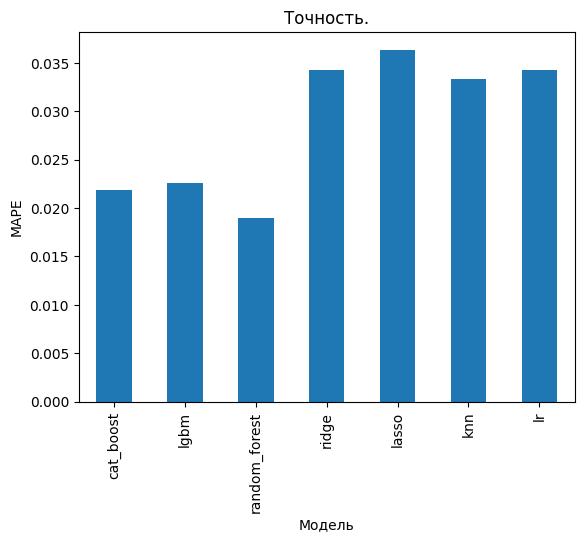

In [38]:
pd.Series(metrics_model).plot(kind = 'bar')
plt.title('Точность.')
plt.xlabel('Модель')
plt.ylabel('MAPE');

<div style="padding:10px 40px 10px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
Лучший результат показал RandomForest. 

In [44]:
pd.Series(rfr.feature_importances_, index=train_features.columns).sort_values(ascending = False)

year                         0.557055
make_model                   0.113903
odometer                     0.093711
trim                         0.036992
condition_div_by_odometer    0.035583
body                         0.032699
model                        0.028326
make                         0.025304
condition                    0.023799
odometer_div_by_age          0.009807
state                        0.006798
interior                     0.006320
transmission                 0.005967
color                        0.005682
year_difference              0.005135
sale_day                     0.003880
sale_hour                    0.003329
sale_month                   0.002059
sale_minute                  0.001875
sale_dayofweek               0.001620
sale_year                    0.000154
dtype: float64

<div style="padding:10px 40px 10px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color:#E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
    
**Наиважнейшими признаками оказался год**

<div style="padding:0px 20px 20px; 
            color:#004346;
            margin:0px;
            font-size:20px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

# Предсказание лучшей модели на тестовой выборке

In [45]:
total_pipeline = Pipeline(steps=[('simple_preproc', simple_preproc), 
                                 ('imputing_nan', Imputing), 
                                 ('numeric_preroc', numeric_piepline), 
                                 ('numeric_preroc', categ_piepline), 
                                 ('feature_engineering', feature_engineering_piepline),
                                 ('encoding', encoding)])
test = total_pipeline.transform(test)

In [46]:
predict = rfr.predict(test)
predict = np.exp(predict) - 1

pd.DataFrame({'vin': test.index, 'sellingprice': predict}).to_csv('out.csv',index = False)
pd.read_csv('out.csv')

,vin,sellingprice
0,1g6dp567450124779,4324.733081
1,1gtw7fca7e1902207,22327.066958
2,jn8az1mw6dw303497,18924.733473
3,2g1wf5e34d1160703,8787.607955
4,1n6aa0ec3dn301209,19159.020307
...,...,...
110055,1j4aa2d17bl584330,17197.116664
110056,jthbf1d23e5007526,29699.649799
110057,1n4ba41e54c831950,3953.417102
110058,jn1az4eh3dm382431,19292.606159
